# Time Series Models - ARIMA & NeuralProphet

## 1.Importanto / Intalando pacotes

In [55]:
# Intalando/Importanto bibliotecas necessárias

# pip install pmdarima
# pip install prophet
# pip install --upgrade plotly
# pip install neuralprophet

import os #funções para interagir com o sistema operacional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import to_datetime

import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

#ARIMA

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

#NeuralProphet

from neuralprophet import NeuralProphet

%matplotlib inline
                               
# Aumentar o tamalho dos gráficos nos plots do seaborn
sns.set(rc={'figure.figsize':(8,6)})
                               
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

## 2.Formulação do problema

**Previsão de vendas de um supermercado para o próximo ano por categoria**
 

Categorias de produtos:

- Bakery = bake
- Beverages = bev
- Eggs, Meat & Fish = emf
- Food Grains = fg
- Fruits & Veggies = fv
- Oil & Masala = om
- Snacks = sna

## 3.Importanto o dataset

In [56]:
# Importanto o dataset presente no link a seguir: 
# https://www.kaggle.com/datasets/mohamedharris/supermart-grocery-sales-retail-analytics-dataset>

df = pd.read_csv(r'C:\Users\carol\OneDrive\TCC\base\Supermart Grocery Sales - Retail Analytics Dataset.csv', usecols = [2,3, 4, 5,  7])
df = df[['Order Date', 'Category', 'Sales']]
df['Sales'] = df['Sales'].astype(float)
df['Order Date'] = pd.to_datetime(df['Order Date'])
df = df.sort_values(['Order Date', 'Category'])
df.rename(columns={'Order Date': 'date', 'Category': 'category','Sales': 'sales'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9994 entries, 3323 to 908
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      9994 non-null   datetime64[ns]
 1   category  9994 non-null   object        
 2   sales     9994 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 312.3+ KB


## 4.ADF Test

In [57]:
# ADF Test

result = adfuller(df.sales)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
 
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -99.121506
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## 5.Pré processamento

In [58]:
#Resumindo o dataset para meses

df['month'], df['year'] = (df['date'].dt.month, df['date'].dt.year)

df_month = df[['year', "month", 'category', 'sales']]
df_month['date'] = df_month['month'].map(str)+ '-'  +'1'  '-' + df_month['year'].map(str)
df_month['date'] = pd.to_datetime(df_month['date'])

#Sumarizando Sales pelas variáveis restantes

df_sum = df_month.groupby(['date','category']).sum().reset_index()

#Transformando as Categorias em Colunas e preenchendo os valores em branco
df_sum = df_sum.pivot(index='date', columns='category', values='sales') \
.fillna(0) \
.reset_index() \
.rename_axis(None, axis=1)

#Renomeando as colunas
df_sum = df_sum.rename(columns={'Bakery': 'bake',
                       'Beverages': 'bev',
                       'Eggs, Meat & Fish': 'emf',
                       'Food Grains': 'fg',
                       'Fruits & Veggies': 'fv',
                       'Oil & Masala': 'om',
                       'Snacks': 'sna'}, inplace = False)

df_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    48 non-null     datetime64[ns]
 1   bake    48 non-null     float64       
 2   bev     48 non-null     float64       
 3   emf     48 non-null     float64       
 4   fg      48 non-null     float64       
 5   fv      48 non-null     float64       
 6   om      48 non-null     float64       
 7   sna     48 non-null     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 3.1 KB


In [59]:
df_sum.isnull().sum()

date    0
bake    0
bev     0
emf     0
fg      0
fv      0
om      0
sna     0
dtype: int64

<AxesSubplot:>

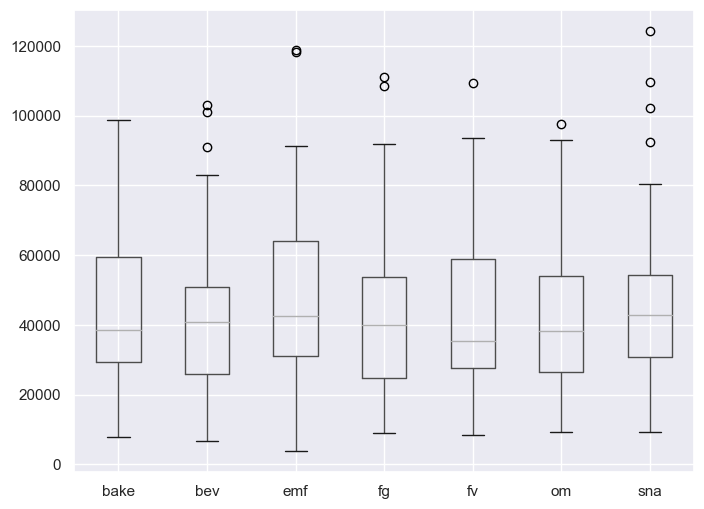

In [60]:
numeric_col = ['bake','bev','emf', 'fg','fv','om', 'sna']
categorical_col = ['date']
df_sum.boxplot(numeric_col)

## 5.Separando os dados (train / test)

In [61]:
#Slice dataframe train & test

X_train = df_sum[df_sum['date'] <= '2017-12-01']
X_test = df_sum[df_sum['date'] > '2017-12-01']

print('X_train Shape', X_train.shape)
print('X_test Shape', X_test.shape)

X_test['date'].unique()

X_train Shape (36, 8)
X_test Shape (12, 8)


array(['2018-01-01T00:00:00.000000000', '2018-02-01T00:00:00.000000000',
       '2018-03-01T00:00:00.000000000', '2018-04-01T00:00:00.000000000',
       '2018-05-01T00:00:00.000000000', '2018-06-01T00:00:00.000000000',
       '2018-07-01T00:00:00.000000000', '2018-08-01T00:00:00.000000000',
       '2018-09-01T00:00:00.000000000', '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [34]:
#def mape(actual, pred): 
   # actual, pred = np.array(actual), np.array(pred)
    #return np.mean(np.abs((actual - pred) / actual)) * 100

## 6.ARIMA (Autoregressive Integrated Moving Average) - 1 Categoria

In [62]:
########################################################################################################
####################################### Rodando ARIMA para Bakery ######################################
########################################################################################################

# Filtrando categoria na base de treino
df_bake_train = X_train[['date','bake']]

# Filtrando categoria na base de teste
df_bake_test = X_test[['date','bake']]

# Configurando a coluna de data como index
df_bake_train.set_index('date', inplace=True)
df_bake_test.set_index('date', inplace=True)

# Configurando o Index para período de teste

index_dates = pd.date_range(df_bake_train.index[-1], freq='MS', periods = 13) 
index_dates = index_dates.delete(0)


index_dates

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [53]:
#Encontrando melhor modelo ARIMA

arima_model = auto_arima(df_bake_train['bake'],start_p = 0, d = 1, start_q = 0,
                          max_p = 5, max_d = 5,max_q = 5, m = 12,
                          error_action = 'warn',
                          trace = True,
                        suppress_warnings = True)

arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=494.227, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=494.237, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=493.522, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=494.148, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=494.591, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=495.368, Time=0.04 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=495.911, Time=0.49 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=495.621, Time=0.03 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=498.727, Time=0.08 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=501.558, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=494.280, Time=0.05 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=503.226, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -243.761
Date:                            Mon, 06 Feb 2023   AIC                            493.522
Time:                                    12:27:35   BIC                            496.929
Sample:                                01-01-2015   HQIC                           494.379
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2751      0.108     -2.545      0.011      -0.487      -0.063
ma.S.L12      -0.0685      0.124     -0.554      0.579      -0.311       0.174
sigma2      9.375e+07   1.56e-10      6e+17      0.000    9.37e+07    9.37e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.27   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.26   Prob(JB):                         0.84
Heteroskedasticity (H):               0.19   Skew:                             0.17
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.79e+33. Standard errors may be unstable.
"""

The RMSE of ARIMA is: 13735.635213982796
The MAPE of ARIMA is: 19.059978279819408


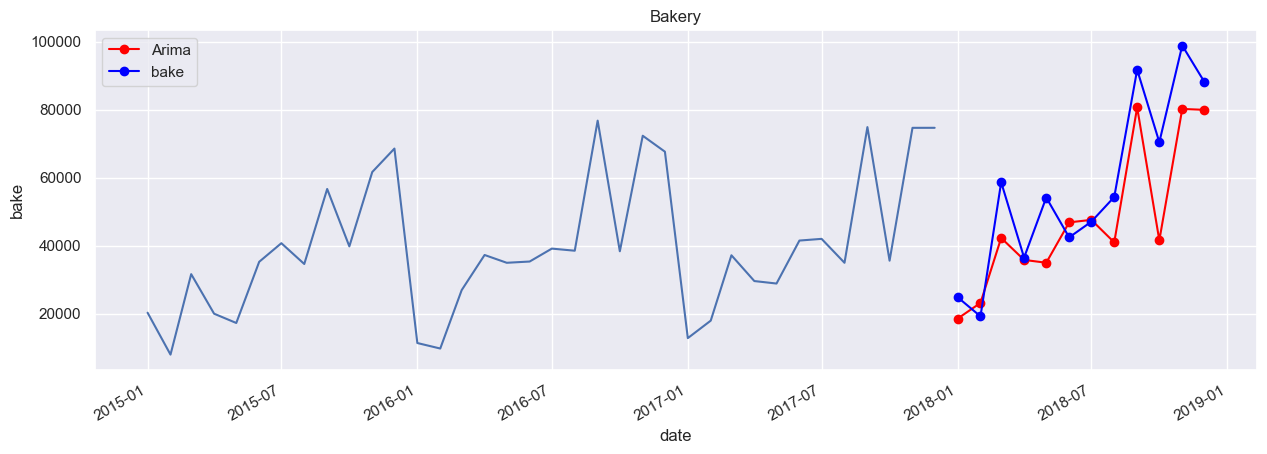

In [64]:
# Rodando ARIMA com base em melhor modelo
model_arima = ARIMA(df_bake_train, order=(0,1,1), seasonal_order = (0,1,1,12))
model_arima_fit = model_arima.fit()

# Salvando predições ARIMA
fcast1 = model_arima_fit.forecast(12)

fcast1 = pd.Series(fcast1.values, index=index_dates)

fcast1 = pd.Series(fcast1.values, index=index_dates)
fcast1 = fcast1.rename("Arima") 

# Plotando previsões
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='date', y='bake', data = df_bake_train)
chart.set_title('Bakery')
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
df_bake_test.plot(ax=ax, color='blue', marker="o", legend=True)

actual = df_bake_test['bake'].values
pred1 = fcast1.values

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# Verificando RMSE/MAPE

print('The RMSE of ARIMA is:',mean_squared_error(df_bake_test['bake'].values, fcast1.values, squared=False))
print('The MAPE of ARIMA is:',mean_absolute_percentage_error(actual, pred1)*100)

## 7.neuralprophet - 1 Categoria

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 88.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 1000
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (3) is too small than the required number for the learning rate finder (203). The results 

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 83.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 83.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 3it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


The RMSE of prophet is: 18181.724959846742
The MAPE of prophet is: 26.071924231575906


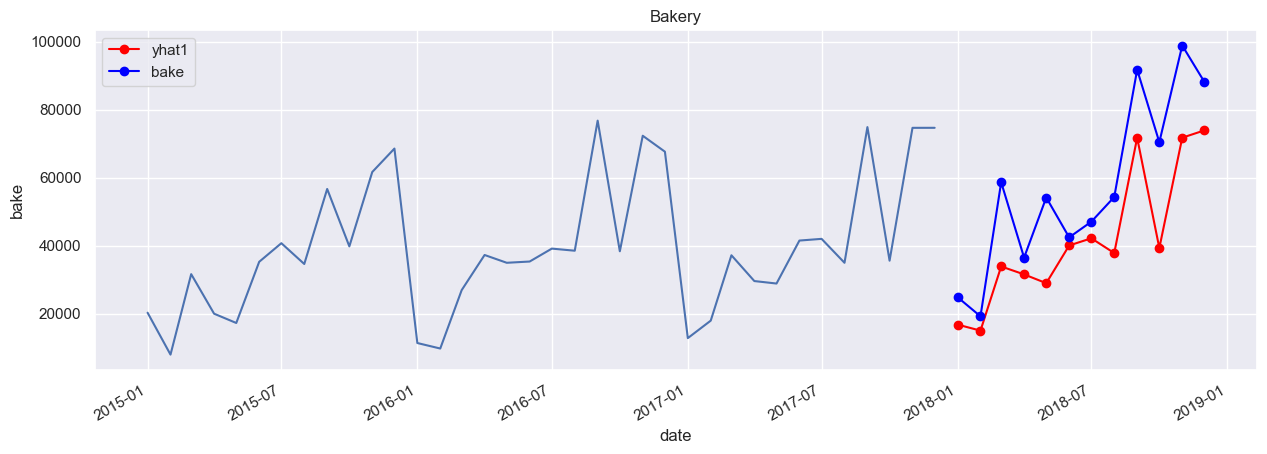

In [65]:
########################################################################################################
####################################### Rodando neuralprophet para Bakery ##############################
########################################################################################################

df_bake_train3 = df_bake_train.copy().reset_index()
df_bake_train3 = df_bake_train3[['date', 'bake']]
df_bake_train3.columns = ['ds', 'y']
df_bake_train3['ds']= to_datetime(df_bake_train3['ds'])

# Definindo o modelo
n_prophet = NeuralProphet()

# Configurando o modelo
n_prophet.fit(df_bake_train3)

# Usando o modelo para realizar previsões

index_dates3 = pd.DataFrame(index_dates)
index_dates3.columns = ['ds']
index_dates3['y'] = 0

fcast4 = n_prophet.predict(index_dates3)

fcast4 = pd.DataFrame(fcast4)
fcast4 = fcast4[['ds', 'yhat1']]
fcast4.set_index('ds', inplace=True)

# Plotando previsões
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='date', y='bake', data = df_bake_train)
chart.set_title('Bakery')
fcast4.plot(ax=ax, color='red', marker="o", legend=True)
df_bake_test.plot(ax=ax, color='blue', marker="o", legend=True)

pred4 = fcast4.values

# Verificando RMSE/MAPE

print('The RMSE of prophet is:',mean_squared_error(df_bake_test['bake'].values, fcast4.values, squared=False))
print('The MAPE of prophet is:',mean_absolute_percentage_error(actual, pred4)*100)